# Movie Review Sentiment Analysis Using BERT

Fine tuning BERT ($BERT_{BASE}$ has total parameters of 110M (L=12, H=768, A=12, Total Parameters=110M) (Devlin et al, 2019, [BERT paper link](https://arxiv.org/pdf/1810.04805.pdf)) for sentiment analysis.


**Dataset**

IMDB dataset has 50K movie reviews for natural language processing.
Please download the dataset from [Kaggle link for IMDB master](https://www.kaggle.com/uttam94/imdb-mastercsv) and preprocess the data. Use the column "type" to seperate training and test datasets if needed as used in this case.

**Problem**

A review in the IMDB dataset is either positive or negative. Therefore, the NLP movie review sentiment analysis task is a supervised learning binary classification problem.

**Settings**

1. Split IMDB training data to 20K and 5K.
2. Use 20K in training a model.
3. Get predictions on 5K train data (model_3_5ktrain.csv) and 25K test data (model_3_25ktest.csv).
4. Two prediction files created in Item 3 are used in SSNet combiner.

In [1]:
# Enable intellisense
%config IPCompleter.greedy=True

In [2]:
# Import modules
import pandas as pd
import numpy as np
import bert
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras.models import  Model
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard
from tqdm import tqdm
import matplotlib.pyplot as plt

print("TensorFlow Version:",tf.__version__)
print("Hub version: ",hub.__version__)
print("GPU is", "available" if tf.config.list_physical_devices('GPU') else "NOT AVAILABLE")
pd.set_option('display.max_colwidth',1000)

TensorFlow Version: 2.2.0
Hub version:  0.9.0
GPU is available


In [3]:
import sys
sys.path.append("./helpers")
import imdb_preprocess_functions as imdb
sys.path.append("../model_helpers")
import model_utils as model_utils
sys.path.append("../bert_helpers")
import bert_functions as iBert
import importlib

## Data preprocessing

In [4]:
# Load imdb master data, return 25K train and 25K test datasets
[df_train, df_test] = imdb.get_imdb_df_data('./data/imdb_master.csv')

The number of rows and columns in the training dataset is: (25000, 5)
Missing values in train dataset:
Unnamed: 0    0
type          0
review        0
label         0
file          0
dtype: int64
Check train class balance
1.0    12500
0.0    12500
Name: label, dtype: int64
The number of rows and columns in the test dataset is: (25000, 5)
Missing values in test dataset:
Unnamed: 0    0
type          0
review        0
label         0
file          0
dtype: int64
Check test class balance
1.0    12500
0.0    12500
Name: label, dtype: int64


In [5]:
# Preprocess 25K train data. Return review texts with label (positive or negative). Train data is reproducibly shuffled.
train_data = text_train, label_train, df_fit_train = imdb.get_fit_data(df_train, True)

In [6]:
# Specify split size. Use this number in training the model
SPLIT_TRAIN_SIZE = 20000

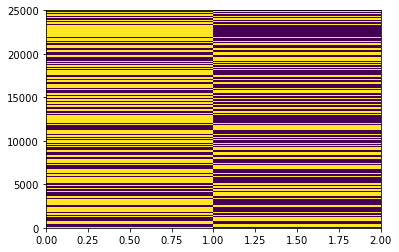

In [7]:
# Plot class districution. Verify it's balanced.
plt.pcolormesh(train_data[1])

In [8]:
# Modelling fine-tuned Bert model
pre_trained_bert_url = "https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/2"
model = iBert.nlp_model(pre_trained_bert_url, 2)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_ids (InputLayer)          [(None, 500)]        0                                            
__________________________________________________________________________________________________
input_masks (InputLayer)        [(None, 500)]        0                                            
__________________________________________________________________________________________________
segment_ids (InputLayer)        [(None, 500)]        0                                            
__________________________________________________________________________________________________
bert_layer (KerasLayer)         [(None, 768), (None, 109482241   input_ids[0][0]                  
                                                                 input_masks[0][0]            

In [9]:
# Get Bert tokenizer
tokenizer = iBert.create_tonkenizer(model.layers[3])

In [10]:
# split train data run
train_final_data = train_data[0][:SPLIT_TRAIN_SIZE], train_data[1][:SPLIT_TRAIN_SIZE], train_data[2][:SPLIT_TRAIN_SIZE]
    
x_train = x_input1, x_input2, x_input3 = iBert.convert_sentences_to_features(train_final_data[0], tokenizer)
y_train = train_final_data[1]

100%|██████████| 20000/20000 [00:58<00:00, 340.78it/s]


## Model training

In [11]:
# Model parameter set
BATCH_SIZE = 8
EPOCHS = 4
LRATE = 2e-5
LOSS = 'categorical_crossentropy'
METRICS = 'accuracy'

# Specify model name
root_name = 'model_bert'
model_file_name = root_name + '_' + str(SPLIT_TRAIN_SIZE) + '_'
model_name = model_file_name + 'epoch_' + str(EPOCHS) + ".h5"

Epoch 1/4
2500/2500 [==============================] - 813s 325ms/step - loss: 0.2561 - accuracy: 0.8960
Epoch 2/4
2500/2500 [==============================] - 815s 326ms/step - loss: 0.1306 - accuracy: 0.9540
Epoch 3/4
2500/2500 [==============================] - 816s 326ms/step - loss: 0.0708 - accuracy: 0.9774
Epoch 4/4
2500/2500 [==============================] - 815s 326ms/step - loss: 0.0455 - accuracy: 0.9850
dict_keys(['loss', 'accuracy'])


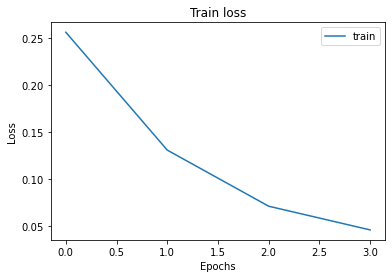

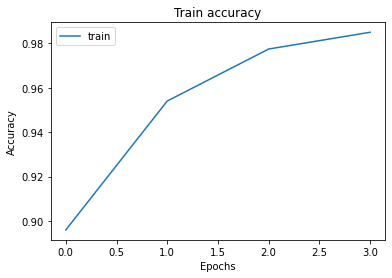

In [12]:
#Train the model

#Use Adam optimizer to minimize the categorical_crossentropy loss
opt = Adam(learning_rate=LRATE)

model.compile(optimizer=opt, 
              loss=LOSS,
              metrics=[METRICS])

# Fit the data to the model
history = model.fit(x_train, y_train,
                    epochs=EPOCHS,
                    batch_size=BATCH_SIZE,
                    verbose = 1)


# Save the trained model
model.save(model_name)
model_utils.get_history(history)

In [13]:
test_data = text_test, label_test, df_fit_test = imdb.get_fit_data(df_test, False)
# Use 5K split train data as test data to get predictions
test_final_data = train_data[0][SPLIT_TRAIN_SIZE:], train_data[1][SPLIT_TRAIN_SIZE:], train_data[2][SPLIT_TRAIN_SIZE:]

x_test = x_input1, x_input2, x_input3 = iBert.convert_sentences_to_features(test_final_data[0], tokenizer)
y_test = test_final_data[1]

100%|██████████| 5000/5000 [00:17<00:00, 292.71it/s]


In [14]:
# Get predictions for test data
prediction_prob = model_utils.get_model_performance(model_name, x_test, y_test, 128)

40/40 [==============================] - 63s 2s/step - loss: 0.3307 - accuracy: 0.9270
[0.33069083094596863, 0.9269999861717224]
              precision    recall  f1-score   support

           0     0.9140    0.9422    0.9279      2492
           1     0.9408    0.9119    0.9261      2508

    accuracy                         0.9270      5000
   macro avg     0.9274    0.9270    0.9270      5000
weighted avg     0.9274    0.9270    0.9270      5000



In [15]:
# Create prediction output for 5K from split train
result_file_root_name = root_name + '_result'
run_type = 2 #split run
model_utils.output_result(test_final_data[2], result_file_root_name, run_type, prediction_prob, SPLIT_TRAIN_SIZE)

100%|██████████| 25000/25000 [01:23<00:00, 299.36it/s]


196/196 [==============================] - 322s 2s/step - loss: 0.3204 - accuracy: 0.9300
[0.3204316794872284, 0.9299600124359131]
              precision    recall  f1-score   support

           0     0.9171    0.9454    0.9310     12500
           1     0.9436    0.9146    0.9289     12500

    accuracy                         0.9300     25000
   macro avg     0.9304    0.9300    0.9299     25000
weighted avg     0.9304    0.9300    0.9299     25000



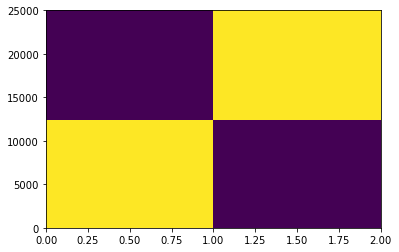

In [16]:
# Run prediction for 25k test data 
x_test = x_input1, x_input2, x_input3 = iBert.convert_sentences_to_features(test_data[0], tokenizer)
y_test = test_data[1]
plt.pcolormesh(y_test)
prediction_prob = model_utils.get_model_performance(model_name, x_test, y_test, 128)

In [17]:
# Create prediction output for 25K test
model_utils.output_result(test_data[2], result_file_root_name,run_type, prediction_prob, SPLIT_TRAIN_SIZE)

In [18]:
# Rename files for SSNet combiners
import os
os.rename(r'model_bert_result_split_25000_20000.csv',r'model_3_25ktest.csv')
os.rename(r'model_bert_result_split_5000_20000.csv',r'model_3_5ktrain.csv')